In [2]:
import os 
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt

Define functions to:
- Decode GT flow
- Calculate flow metrics (MSEN, PEPN)
- Plot errors and flows

Functions for metric calculation and error plotting were originally implemented by Group 5 of the 2023 cohort.

In [198]:
def read_flow(path:str):
    """
    Optical flow maps are saved as 3-channel uint16 PNG images: The first channel
    contains the u-component, the second channel the v-component and the third
    channel denotes if a valid ground truth optical flow value exists for that
    pixel (1 if true, 0 otherwise)
    """
    # cv2 flips the order of reading channels
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.double)
    
    # valid channel
    valid = img[:,:,0]
    
    # get flow vectors
    u_flow = (img[:,:,2] - 2**15)/64
    v_flow = (img[:,:,1] - 2**15)/64
    
    # remove invalid flow values
    u_flow[valid == 0] = 0
    v_flow[valid == 0] = 0
    
    # return image in correct order
    return np.dstack((u_flow, v_flow, valid))

def plot_flow(img):
    """
    plot u and v flows along with valid pixels
    """
    fig, axes = plt.subplots(1,3, figsize=(16,8))
    images = [img[:,:,0], img[:,:,1], img[:,:,2]]
    titles = ['u_flow','v_flow','valid']    
    for ax,image,title in zip(axes.flatten(), images, titles):
        ax.imshow(image, cmap='gray')
        ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

    
def plotError(img, outputFile):
    path = "./plots"
    
    plt.figure(figsize=(9, 3))
    plt.title('Squared error for ' + outputFile)
    plt.imshow(img)
    plt.colorbar()
    plt.savefig(path + '/' + outputFile +'.png')


def plotValid(img, outputFile):
    path = "./plots"
    
    plt.figure(figsize=(12,9))
    plt.title("Valid pixels for " + outputFile)
    plt.imshow(img, cmap='gray')
    plt.savefig(path + '/' + outputFile +'_valid_pixels_GT.png')

def plotErrorHistogram(img, outputFile):
    path = "./plots"
    print(img.shape)
    # create the histogram
    histogram, bin_edges = np.histogram(img, bins=50, density=True)
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.figure()
    plt.title("Image " + outputFile + " Squared Error Histogram")
    plt.xlabel("Squared error")
    plt.ylabel("Pixel percentage")
    plt.xlim([0, 50])

    plt.bar(center, histogram)
    #plt.plot(bin_edges[0:-1], histogram) 
    plt.savefig(path + '/' + outputFile +'_error_histogram.png')

def calculateMetrics(img, img_gt, valid_gt, plot = False, outputFile = "hist"):
    """
    Calculating The Mean Square Error and Percentage of Erroneous Pixels in non-ocluded areas
    
    Args:
        img: the predicted numpy.ndarray
        img_gt: the groundtruth of the prediction. It is also a numpy.ndarray
        valid_gt: the valid pixels
        ouputFile: Where you want to save the result.
    Return:
        msen: Mean Square Error in non-ocluded areas.
        pepn: Percentage of Erroneous Pixels in non-ocluded areas.
    """
    # Get x and y values
    x_gt = img_gt[:,:,0]
    y_gt = img_gt[:,:,1]
    x_img = img[:,:,0]
    y_img = img[:,:,1]

    # is calculated for every pixel
    motion_vectors = np.sqrt( np.square(x_img - x_gt) + np.square(y_img - y_gt) )

    if plot:
        plotError(motion_vectors, outputFile)
        plotValid(valid_gt, outputFile)
        plotErrorHistogram(motion_vectors[valid_gt == 1], outputFile)

    # erroneous pixels are the ones where motion_vector > 3 and are valid pixels 
    err_pixels = (motion_vectors[valid_gt == 1] > 3).sum()

    # calculate metrics
    msen = np.mean((motion_vectors)[valid_gt == 1])
    pepn = (err_pixels / (valid_gt == 1).sum()) * 100 # erroneous pixels / total valid pixels from the ground truth

    return msen, pepn

# Function to visualize optical flow and ground truth
def visualize_flow(gt_flow, est_flow, image):
    # Convert flow arrays to color images
    gt_flow_vis = flow_to_color(gt_flow)
    est_flow_vis = flow_to_color(est_flow)

    # Plot optical flow and ground truth
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image[..., ::-1])  # Display original image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_flow_vis)  # Display ground truth optical flow
    plt.title('Ground Truth Flow')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(est_flow_vis)  # Display estimated optical flow
    plt.title('Estimated Flow')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function to convert flow array to color image
def flow_to_color(flow):
    h, w, _ = flow.shape
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

Read OCC and NOC ground truths from file and store variables for evaluation later.

In [187]:
def read_flow_from_file(file_path):

    raw_flow = read_flow(file_path)
    x_gt = raw_flow[:,:,0]
    y_gt = raw_flow[:,:,1]
    valid_gt = raw_flow[:,:,2]
    flow_gt = np.stack((x_gt, y_gt), axis = 2)

    return flow_gt, valid_gt


occ_flow_gt, occ_valid_gt = read_flow_from_file("/home/georg/projects/university/C6/mcv-c6-2024-team3/Week3/data/training/flow_occ/000045_10.png")
noc_flow_gt, noc_valid_gt = read_flow_from_file("/home/georg/projects/university/C6/mcv-c6-2024-team3/Week3/data/training/flow_noc/000045_10.png")


## PyFlow Estimator
Define class for running PyFlow based on `demo.py` from the PyFlow repository

In [188]:
from pyflow import pyflow 

class PyFlowEstimator():
    def __init__(self, alpha = 0.012, ratio = 0.75, minWidth = 20, nOuterFPIterations = 7, nInnerFPIterations = 1, nSORIterations = 30, colType = 0):
        self.alpha = alpha
        self.ratio = ratio
        self.minWidth = minWidth
        self.nOuterFPIterations = nOuterFPIterations
        self.nInnerFPIterations = nInnerFPIterations
        self.nSORIterations = nSORIterations
        self.colType = colType

    def preprocess_image(self, img_path):
        img = cv2.imread(img_path, 0)
        img = img[:,:,np.newaxis]

        img = img.astype(float) / 255.
        return img
        
    def estimate(self, img1_path, img2_path):
        img1 = self.preprocess_image(img1_path)
        img2 = self.preprocess_image(img2_path)
        
        u, v, im2W = pyflow.coarse2fine_flow(
                                        img1, 
                                        img2, 
                                        self.alpha,
                                        self.ratio,
                                        self.minWidth, 
                                        self.nOuterFPIterations,
                                        self.nInnerFPIterations,
                                        self.nSORIterations, 
                                        self.colType)
     
        flow = np.dstack((u, v))

        return flow


In [189]:
img1_path = '/home/georg/projects/university/C6/mcv-c6-2024-team3/Week3/data/training/image_0/000045_10.png'
img2_path = '/home/georg/projects/university/C6/mcv-c6-2024-team3/Week3/data/training/image_0/000045_11.png'

estimator = PyFlowEstimator()
flow = estimator.estimate(img1_path, img2_path)

Constructing pyramid...done!
Pyramid level 13
Pyramid level 12
Pyramid level 11
Pyramid level 10
Pyramid level 9
Pyramid level 8
Pyramid level 7
Pyramid level 6
Pyramid level 5
Pyramid level 4
Pyramid level 3
Pyramid level 2
Pyramid level 1
Pyramid level 0


(110744,)
MSEN: 1.1464428326523917
PEPN: 9.569818680921765
(104330,)
MSEN: 0.9363538424316532
PEPN: 7.429310840601937


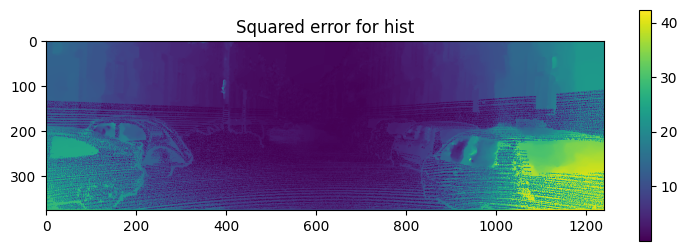

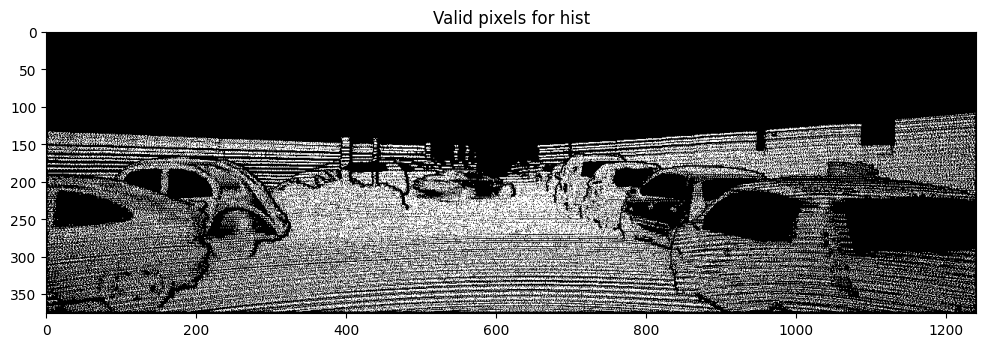

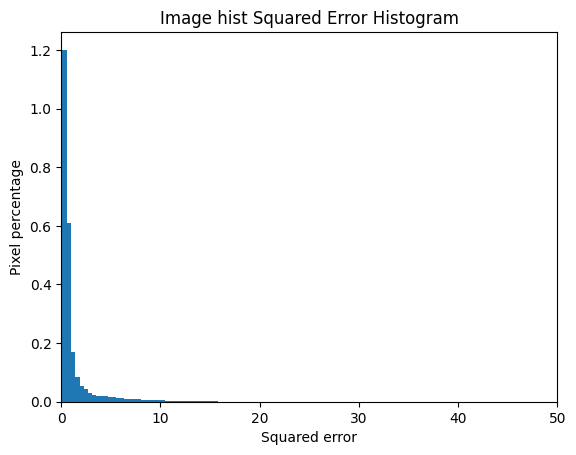

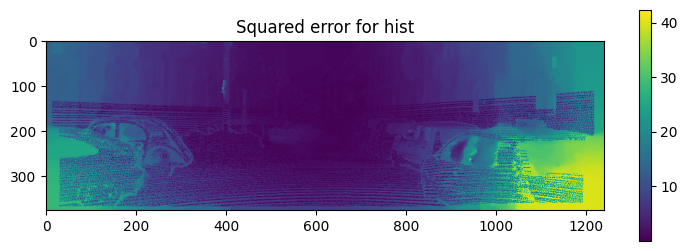

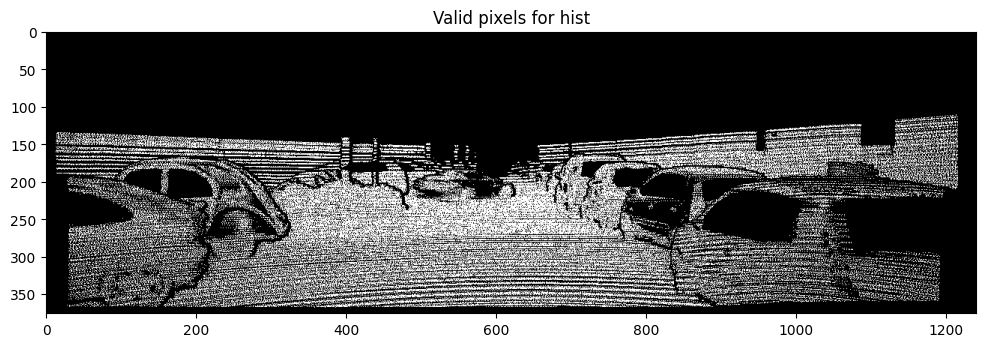

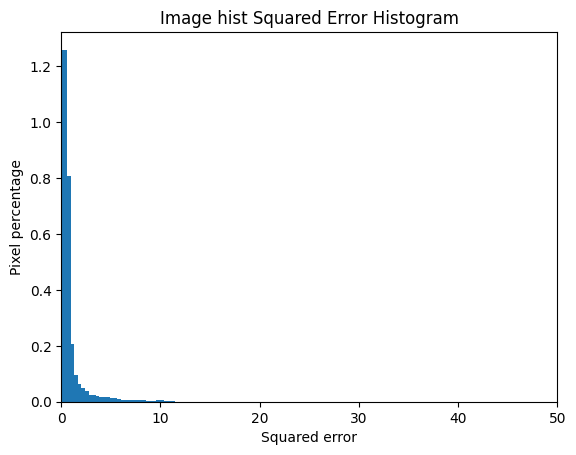

In [190]:
msen, pepn = calculateMetrics(flow, occ_flow_gt, occ_valid_gt, plot=True)

print(f'MSEN: {msen}')
print(f'PEPN: {pepn}')

msen, pepn = calculateMetrics(flow, noc_flow_gt, noc_valid_gt, plot=True)

print(f'MSEN: {msen}')
print(f'PEPN: {pepn}')



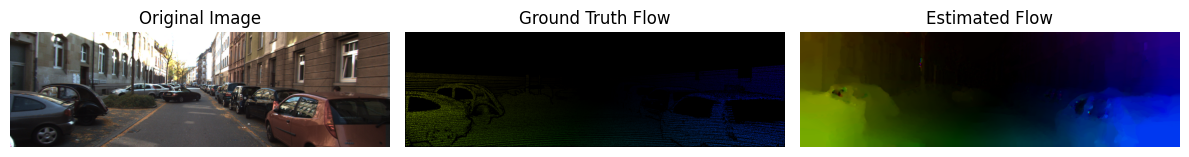

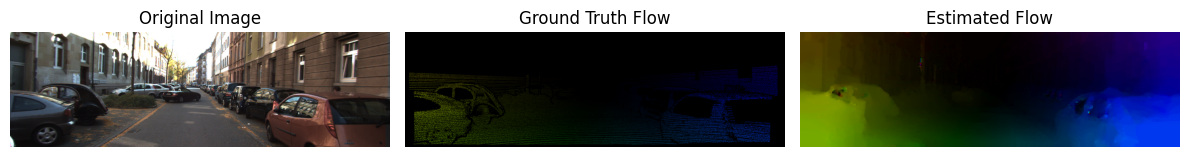

In [191]:
# Load the corresponding image
image = cv2.imread('/home/georg/projects/university/C6/mcv-c6-2024-team3/Week3/data/training/colored_0/000045_10.png', cv2.IMREAD_COLOR)  # Read original image
# Visualize optical flow and ground truth
visualize_flow(occ_flow_gt, np.array(flow), image)
visualize_flow(noc_flow_gt, np.array(flow), image)

In [192]:
# PerceiverIO imports 
import functools
import itertools
import pickle

import haiku as hk
import jax
import jax.numpy as jnp
import imageio
from perceiver import perceiver, io_processors
from task1_2_utils import *

## PerceiverIO Optical Flow Estimator

In [193]:
class PerceiverIOEstimator():
    def __init__(self):
        
        self.optical_flow = hk.transform(optical_flow)
        self.apply_fn = jax.jit(self.optical_flow.apply)

        os.system('wget -O optical_flow_checkpoint.pystate https://storage.googleapis.com/perceiver_io/optical_flow_checkpoint.pystate')

        self.rng = jax.random.PRNGKey(42)
        with open("optical_flow_checkpoint.pystate", "rb") as f:
            self.params = pickle.loads(f.read())
        self.state = {}
        self.TRAIN_SIZE = (368, 496)

    def preprocess_image(self, img_path):
        with open(img_path, "rb") as f:
            img = imageio.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = img / 255.0 * 2 - 1
        return img
    
    def estimate(self, img1_path, img2_path):
        img1 = self.preprocess_image(img1_path)
        img2 = self.preprocess_image(img2_path)

        grid_indices = compute_grid_indices(img1.shape, patch_size=self.TRAIN_SIZE)
        flow = compute_optical_flow(self.params, self.rng, img1, img2, grid_indices, patch_size=self.TRAIN_SIZE, apply_fn=self.apply_fn)
        return flow[0]


In [194]:
img1_path = '/home/georg/projects/university/C6/mcv-c6-2024-team3/Week3/data/training/image_0/000045_10.png'
img2_path = '/home/georg/projects/university/C6/mcv-c6-2024-team3/Week3/data/training/image_0/000045_11.png'

estimator = PerceiverIOEstimator()
flow = estimator.estimate(img1_path, img2_path)

--2024-03-13 13:58:22--  https://storage.googleapis.com/perceiver_io/optical_flow_checkpoint.pystate
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.184.187, 142.250.200.91, 142.250.201.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.184.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164271840 (157M) [application/octet-stream]
Saving to: ‘optical_flow_checkpoint.pystate’

     0K .......... .......... .......... .......... ..........  0%  287K 9m18s
    50K .......... .......... .......... .......... ..........  0%  403K 7m58s
   100K .......... .......... .......... .......... ..........  0% 1,06M 6m8s
   150K .......... .......... .......... .......... ..........  0% 1008K 5m16s
   200K .......... .......... .......... .......... ..........  0% 1,17M 4m39s
   250K .......... .......... .......... .......... ..........  0% 1,76M 4m7s
   300K .......... .......... .......... .......... ..........  0% 2,64

(110744,)
MSEN: 0.8085559606552124
PEPN: 5.6653182113703675
(104330,)
MSEN: 0.7329338788986206
PEPN: 4.590242499760376


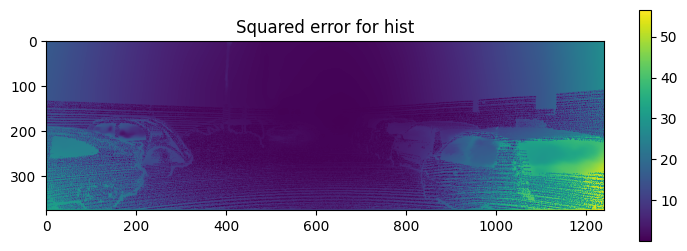

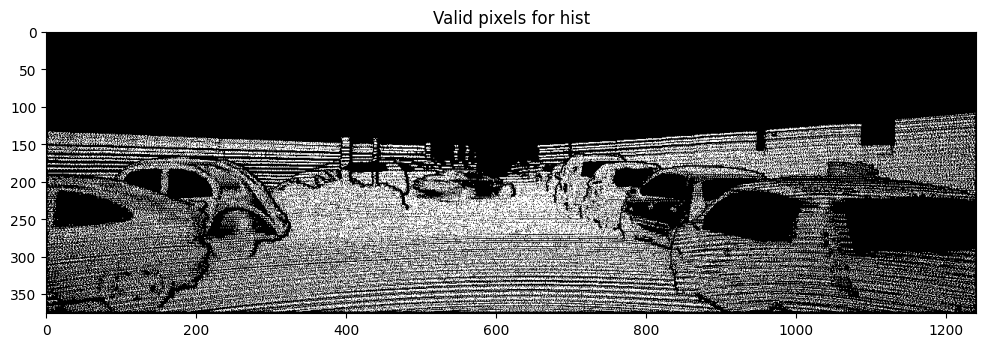

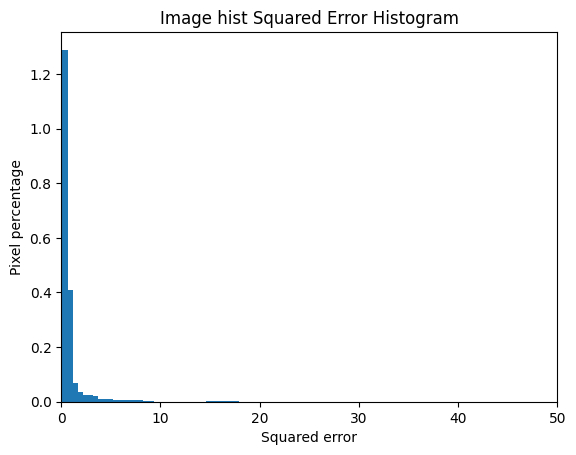

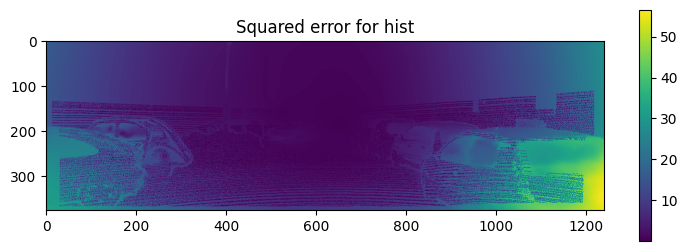

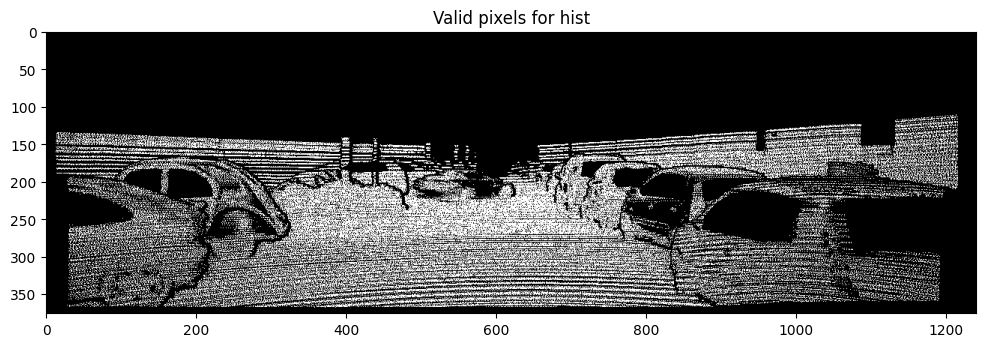

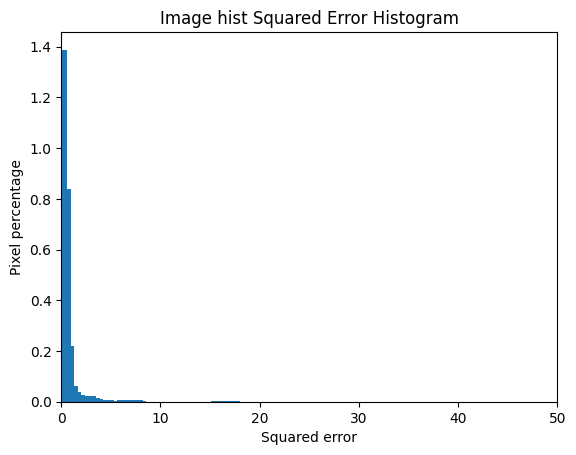

In [196]:
msen, pepn = calculateMetrics(flow, occ_flow_gt, occ_valid_gt, plot=True)

print(f'MSEN: {msen}')
print(f'PEPN: {pepn}')

msen, pepn = calculateMetrics(flow, noc_flow_gt, noc_valid_gt, plot=True)

print(f'MSEN: {msen}')
print(f'PEPN: {pepn}')

## GMFlow 
The GMFow repo by Unimatch is quite a complex beast. To get it to work we altered their script in `unimatch/evaluate_flow.py` to save the flow as a `.npy` instead of an image and read results from that file for evaluation in a later step. 

In [200]:
os.system('CUDA_VISIBLE_DEVICES=0 python unimatch/main_flow.py \
                                    --inference_dir unimatch/images_bw \
                                    --resume unimatch/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth \
                                    --output_path output/gmflow-scale2-regrefine6-images_bw \
                                    --padding_factor 32 \
                                    --upsample_factor 4 \
                                    --num_scales 2 \
                                    --attn_splits_list 2 8 \
                                    --corr_radius_list -1 4 \
                                    --prop_radius_list -1 1 \
                                    --reg_refine \
                                    --num_reg_refine 6')

Load checkpoint: unimatch/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth
2 images found


/home/georg/projects/.venv/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Done!


0

(376, 1241, 2)
(104330,)
MSEN: 0.37974231878965903
PEPN: 0.4619955909134477
(110744,)
MSEN: 0.4276956627020438
PEPN: 1.131438272050856


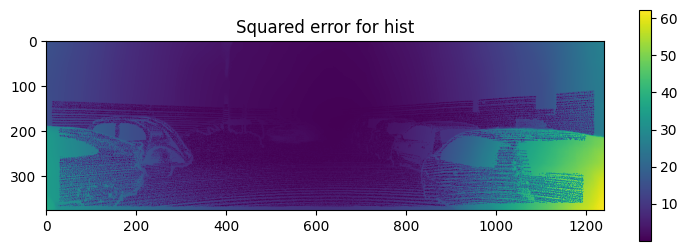

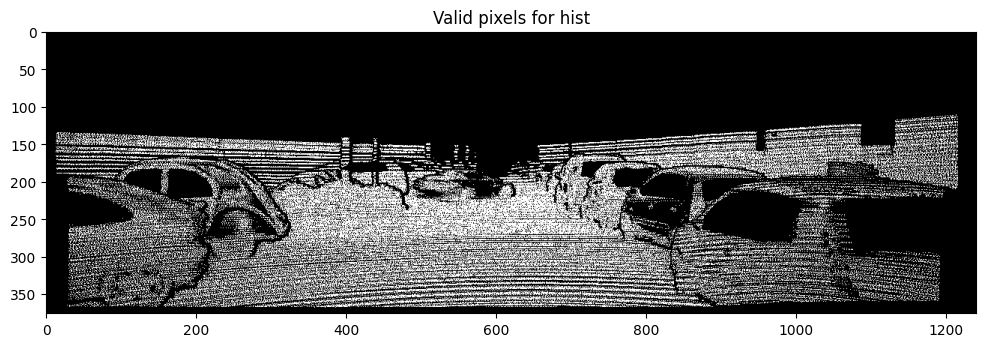

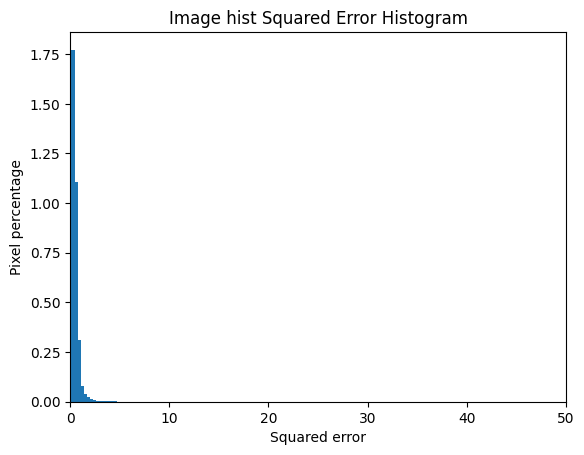

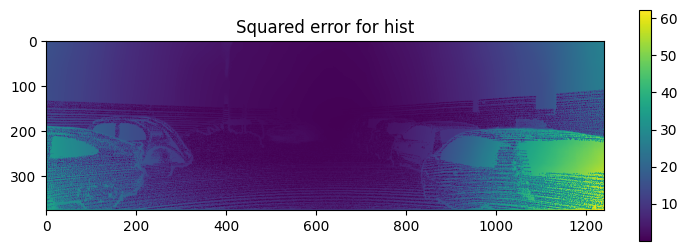

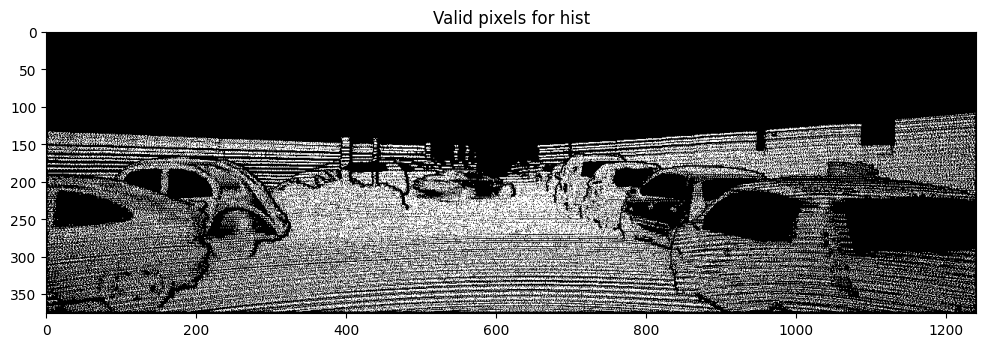

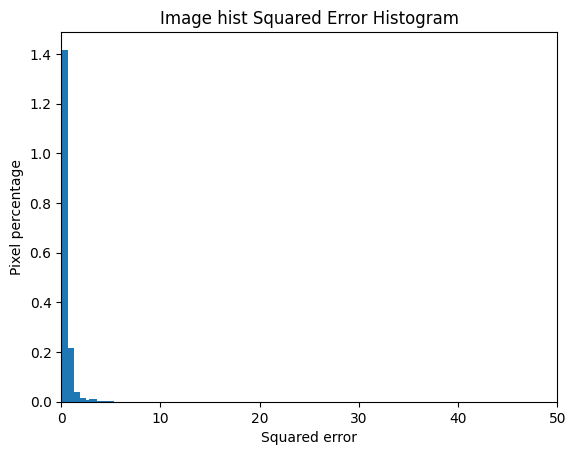

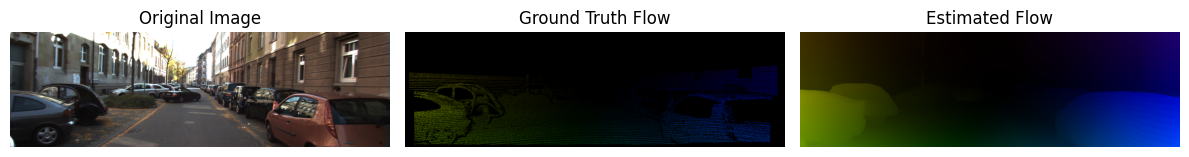

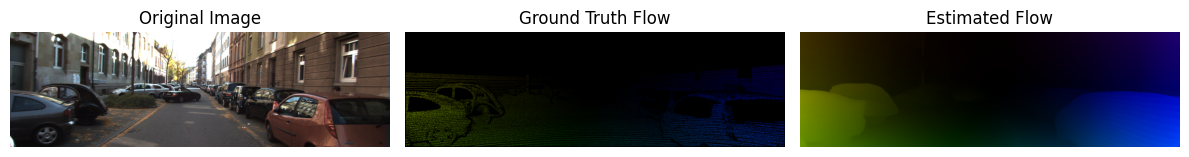

In [203]:
# read GMFlow outputs from .npy file
gm_flow = np.load('/home/georg/projects/university/C6/mcv-c6-2024-team3/Week3/output/gmflow-scale2-regrefine6-images_bw/000045_10_flow.npy')
print(gm_flow.shape)
x_gm = gm_flow[:,:,0]
y_gm = gm_flow[:,:,1]
gm_flow = np.stack((x_gm, y_gm), axis = 2)

#visualize_flow(flow_gt, gm_flow, image)
msen, pepn = calculateMetrics(gm_flow, noc_flow_gt, noc_valid_gt, plot=True)
print(f'MSEN: {msen}')
print(f'PEPN: {pepn}')
msen, pepn = calculateMetrics(gm_flow, occ_flow_gt, occ_valid_gt, plot=True)
print(f'MSEN: {msen}')
print(f'PEPN: {pepn}')

visualize_flow(noc_flow_gt, gm_flow, image)
visualize_flow(occ_flow_gt, gm_flow, image)
